In [10]:
import sys 
sys.path.append('../')
import os
from deephive.environment.deephive_utils import *
from deephive.environment.utils import *
import numpy as np 
from deephive.exploration.gp_surrogate import GPSurrogateModule
from deephive.environment.utils import filter_points
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
import json

In [11]:
def get_agent_actions(env, policy, obs, config, roles=None, split_agents=False,
                      split_type="use_stds", decay_std=False):
    if decay_std:
        policy.std_controller.decay_std()
    if split_agents==False:
        if config["variable_std"][0] == True:
            obs_std = policy.std_controller.get_all_std()
            actions = get_action(obs, policy, env, obs_std)
        else:
            actions = get_action(obs, policy, env)
        return actions
    elif split_agents==True:
        assert roles is not None, "Roles must be provided if split_agents is True"
        exploiters_id = np.where(roles[0] == 1)[0]
        explorers_id = np.where(roles[0] == 0)[0]
        if split_type == "use_stds":
            policy.std_controller.update_roles(roles)
            obs_std = policy.std_controller.get_all_std()
            assert config['variable_std'][0] == True, "variable_std must be True in config"
            assert config['role_std']['explorer'] > config['role_std']['exploiter'], "explorers must have higher std than exploiters"
            actions = get_action(obs, policy, env, obs_std)
            return actions
        elif split_type == "use_grid":
            policy.std_controller.update_roles(roles)
            obs_std = policy.std_controller.get_all_std()
            explorer_actions, next_points = get_informed_action(env, env.n_agents)
            exploiter_actions = get_action(obs, policy, env, obs_std)
            actions = np.zeros((env.n_agents, env.n_dim))
            actions[explorers_id] = explorer_actions[explorers_id]
            actions[exploiters_id] = exploiter_actions[exploiters_id]
            return actions
        elif split_type == "use_two_policies":
            policy[0].std_controller.update_roles(roles)
            obs_std = policy[0].std_controller.get_all_std()
            obs_explore, roles = env.observation_schemes.generate_observation(pbest=env.pbest.copy(), use_gbest=False, ratio=env.split_ratio)
            obs_exploit, roles = env.observation_schemes.generate_observation(pbest=env.pbest.copy(), use_gbest=True, ratio=env.split_ratio)
            exploit_std_obs = policy[1].std_controller.get_all_std(std=config["exploit_std"])
            assert len(policy) == 2, "Two policies must be provided - first policy is for explorers and second policy is for exploiters"
            explorer_actions = get_action(obs_explore, policy[0], env, obs_std)
            exploiter_actions = get_action(obs_exploit, policy[1], env, exploit_std_obs)
            actions = np.zeros((env.n_agents, env.n_dim))
            actions[explorers_id] = explorer_actions[explorers_id]
            actions[exploiters_id] = exploiter_actions[exploiters_id]
            return actions
        else:
            raise ValueError("split_type must be either use_stds, use_grid or use_two_policies")


def run_experiment(env, agent_policy, config, exp_name, save_gif=False):
    result_path = 'experiments/results/' + exp_name + '/'
    os.makedirs(result_path, exist_ok=True)
    
    if isinstance(agent_policy, list):
        assert config['split_agents'] == True, "split_agents must be True in config"
        assert config['split_type'] == "use_two_policies", "split_type must be use_two_policies in config"
        assert len(agent_policy) == 2, "Two policies must be provided - first policy is for explorers and second policy is for exploiters"
    
    opt_value = env.objective_function.optimal_value(dim=env.n_dim)
    gbestVals = []
    for iter in range(config['iters']):
        obs, roles = env.reset()
        if isinstance(agent_policy, list):
            agent_policy[0].std_controller.reset_std()
            agent_policy[1].std_controller.reset_std()
        else:
            agent_policy.std_controller.reset_std()
        episode_gbest = []
        episode_gbest.append(env.gbest[-1])
        decay_std_run = False
        for i in range(config['ep_length']):
            if i == config['decay_start']:
                #print("Starting to decay std ...")
                decay_std_run = config['decay_std']
            actions = get_agent_actions(env, agent_policy, obs, config, roles=roles, split_agents=config["split_agents"], split_type=config["split_type"], decay_std=decay_std_run)
            observation_info, _, _, _ = env.step(actions)
            obs, roles = observation_info
            
            episode_gbest.append(env.gbest[-1])

        if env.gbest[-1] < config['tol'] * opt_value:
            print(f"[WARNING - iter {iter}] - Optimization failed to get to {config['tol']}% of optimal value - {opt_value}")
            print(f"Best value found: {env.gbest[-1]}")
            print("Rendering the episode history ...")
            print("------------------------------------------")
            env.render(type="history", file_path=result_path + "error_history_" + str(iter) + "_.gif")
        if save_gif:
            if i % 10 == 0:
                env.render(type="history", file_path=result_path + "history_" + str(iter) + "_.gif")
        gbestVals.append(episode_gbest)
        
    # save gbestVals
    np.save(result_path + "gbestVals.npy", np.array(gbestVals))
        
    if config['plot_gbest']:
            num_function_evaluation(fopt=gbestVals ,n_agents=env.n_agents, save_dir=result_path + "num_function_evaluations.png", opt_value=opt_value,
                                    log_scale=False, plot_error_bounds=True)
            plot_individual_function_evaluation(fopt=gbestVals ,n_agents=env.n_agents, save_dir=result_path + "num_function_evaluations2.png", opt_value=opt_value,
                                    log_scale=False)
            
    run_summary = {
    "split_agents": config['split_agents'],
    "split_type": config['split_type'],
    "decay_std": config['decay_std'],
    "decay_start": config['decay_start'],
    "freeze": config['freeze'],
    "use_gbest": config['use_gbest'],
    "variable_std": config['variable_std'],
    "role_std": config['role_std'],
    "decay_std": config['decay_std'],
}
    
    with open(result_path + "run_summary.json", 'w') as f:
        json.dump(run_summary, f)
        

In [12]:
# #Experiment 1: VARIANCE DRIVEN EXPLORERS AND EXPLOITERS
config_path = "../config/exp_config.json"
model_path = "../models/pbest_unfreeze.pth"
model_path_2 = "../models/gbest.pth"

config = parse_config(config_path)


## MANUAL INSPECTION

In [ ]:
# obs, roles = env.reset()
# pbest_policy.std_controller.reset_std()
# # env.render()
# for i in range(10):
#     pbest_policy.std_controller.decay_std()
#     pbest_policy.std_controller.update_roles(roles)
#     observation_std = pbest_policy.std_controller.get_all_std()
#     # print(observation_std[0])
#     # print(env.gbest)
#     exploiters_id = np.where(roles[0] == 1)[0]
#     explorers_id = np.where(roles[0] == 0)[0]
#     actions = get_action(obs, observation_std, pbest_policy, env)
#     observation_info, reward, done, info = env.step(actions)
#     obs, roles = observation_info
#     # env.render()


# NO SPLITTING

## NO SPLITTING - DECAY STD - UNFREEZE - 4

In [14]:
exp_num = 42
iters = 10
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = False
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.2, 'exploiter': 0.2}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = True
config['decay_start'] = 0
config['split_agents'] = False
config['split_type'] = "use_stds"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
mode = "test"
env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, pbest_policy, config, exp_name)

Loaded policy from:  ../models/pbest_unfreeze.pth
Loaded policy from:  ../models/gbest.pth
Saving plot to:  experiments/results/exp_42/num_function_evaluations.png


## NO SPLITTING - DECAY STD - FREEZE - 6

Loaded policy from:  ../models/pbest_unfreeze.pth
Loaded policy from:  ../models/gbest.pth
[WARNING - iter 7] - Optimization failed to get to 0.99% of optimal value - 4.808
Best value found: 4.389496220397939
Rendering the episode history ...
------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  experiments/results/exp_60/error_history_7_.gif
[WARNING - iter 14] - Optimization failed to get to 0.99% of optimal value - 4.808
Best value found: 4.393133017568801
Rendering the episode history ...
------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  experiments/results/exp_60/error_history_14_.gif
[WARNING - iter 16] - Optimization failed to get to 0.99% of optimal value - 4.808
Best value found: 4.39329332183535
Rendering the episode history ...
------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  experiments/results/exp_60/error_history_16_.gif
[WARNING - iter 23] - Optimization failed to get to 0.99% of optimal value - 4.808
Best value found: 4.482521248567867
Rendering the episode history ...
------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  experiments/results/exp_60/error_history_23_.gif
[WARNING - iter 80] - Optimization failed to get to 0.99% of optimal value - 4.808
Best value found: 4.391074940597628
Rendering the episode history ...
------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  experiments/results/exp_60/error_history_80_.gif
Saving plot to:  experiments/results/exp_60/num_function_evaluations.png


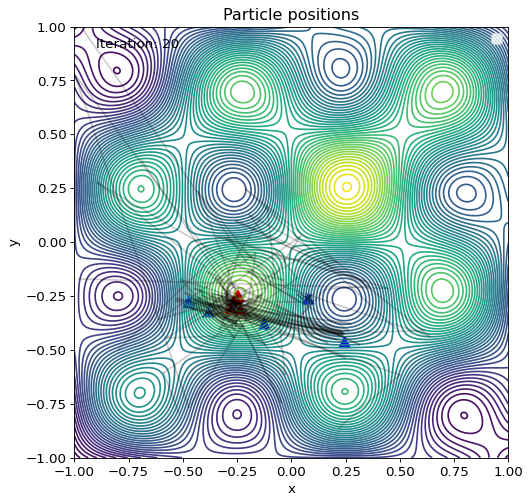

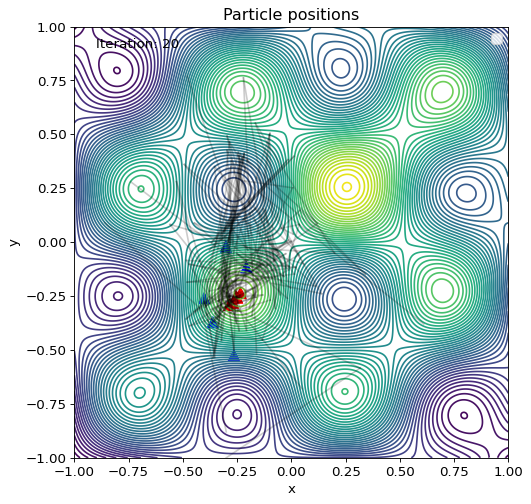

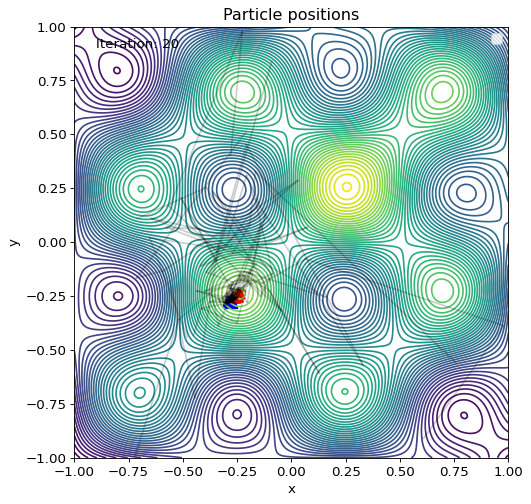

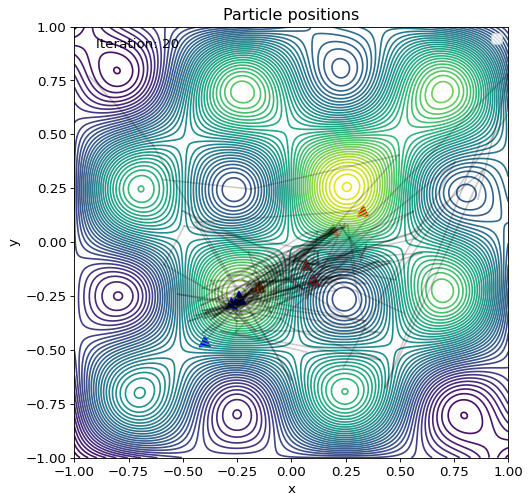

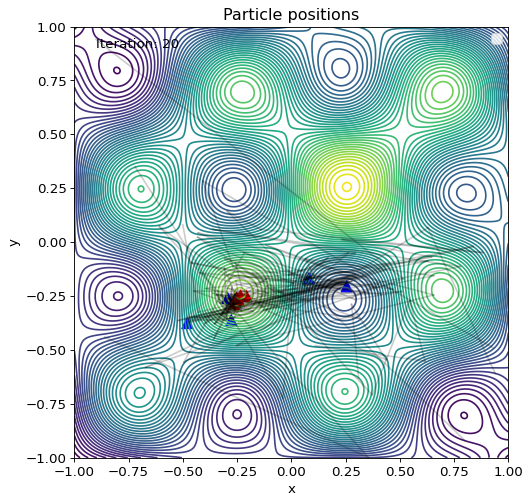

In [15]:
exp_num = 60
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = True
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.3, 'exploiter': 0.3}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = True
config['decay_start'] = 0
config['split_agents'] = False
config['split_type'] = "use_stds"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
mode = "test"
env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, pbest_policy, config, exp_name)

## NO SPLITTING - WITH DECAYED STD - DELAYED DECAY - 5, 7, 8

In [ ]:
exp_num = 9
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = False
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.4, 'exploiter': 0.4}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = True
config['decay_start'] = 4
config['split_agents'] = False
config['split_type'] = "use_stds"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
mode = "test"
env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, pbest_policy, config, exp_name)

NO SPLITTING - WITH DECAYED STD - DELAYED DECAY - FREEZE - 9 & 10

In [ ]:
exp_num = 10
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = True
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.4, 'exploiter': 0.4}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.95
config['decay_std'] = True
config['decay_start'] = 4
config['split_agents'] = False
config['split_type'] = "use_stds"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
mode = "test"
env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, pbest_policy, config, exp_name)

In [5]:
env.reset()

([array([[ 0.6649,  0.    ,  0.    ,  0.    ,  0.    ,  0.095 , -0.0742,
           0.095 , -0.0742],
         [ 0.5736,  0.    ,  0.    ,  0.    ,  0.    ,  0.09  , -0.0913,
           0.09  , -0.0913],
         [ 0.7104,  0.    ,  0.    ,  0.    ,  0.    ,  0.08  , -0.2535,
           0.08  , -0.2535],
         [ 0.6432,  0.    ,  0.    ,  0.    ,  0.    ,  0.11  ,  0.0696,
           0.11  ,  0.0696],
         [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , -0.61  , -1.    ,
          -0.61  , -1.    ],
         [ 1.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.635 ,  0.6444,
           0.635 ,  0.6444],
         [ 0.2657,  0.    ,  0.    ,  0.    ,  0.    , -0.2   , -0.4447,
          -0.2   , -0.4447],
         [ 0.3556,  0.    ,  0.    ,  0.    ,  0.    , -0.42  , -0.2876,
          -0.42  , -0.2876],
         [ 0.9639,  0.    ,  0.    ,  0.    ,  0.    ,  0.265 ,  0.9639,
           0.265 ,  0.9639],
         [ 0.7391,  0.    ,  0.    ,  0.    ,  0.    , -0.045 ,  0.4734,
         

## SPLITTING - WITH STDs - 11

In [ ]:
exp_num = 11
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = False
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.2, 'exploiter': 0.02}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = False
config['decay_start'] = 0
config['split_agents'] = True
config['split_type'] = "use_stds"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
mode = "test"

env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, pbest_policy, config, exp_name)

## SPLITTING - TWO POLICIES - 12

In [ ]:
exp_num = 14
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)


config['freeze'] = False
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.4, 'exploiter': 0.4}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = False
config['decay_start'] = 0
config['split_agents'] = True
config['split_type'] = "use_two_policies"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
config['exploit_std'] = 0.02
mode = "test"

env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, agent_policies, config, exp_name)

## SPLITTING - GRID METHOD - 13 and 14

Loaded policy from:  ../models/pbest_unfreeze.pth
Loaded policy from:  ../models/gbest.pth
[WARNING - iter 14] - Optimization failed to get to 0.99% of optimal value - 4.808
Best value found: 4.685046906697786
Rendering the episode history ...
------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  experiments/results/exp_15/error_history_14_.gif
Saving plot to:  experiments/results/exp_15/num_function_evaluations.png


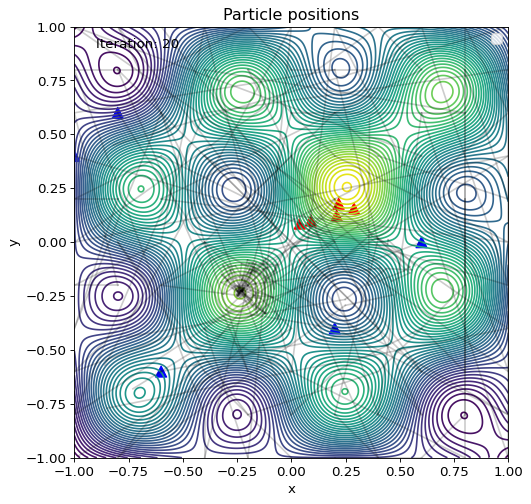

In [7]:
exp_num = 15
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = False
config['use_gbest'] = True
config['role_std'] = {'explorer': 0.02, 'exploiter': 0.02}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = False
config['decay_start'] = 0
config['split_agents'] = True
config['split_type'] = "use_grid"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
config['exploit_std'] = 0.02
mode = "test"

env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, gbest_policy, config, exp_name, save_gif=True)

In [ ]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--title', type=str, default='test')
parser.add_argument('--exp_num', type=int, default=1)
parser.add_argument('--iters', type=int, default=100)
parser.add_argument('--freeze', type=bool, default=False)
parser.add_argument('--use_gbest', type=bool, default=False)
parser.add_argument('--role_std_exploiters', type=float, default=0.2)
parser.add_argument('--role_std_explorers', type=float, default=0.2)
parser.add_argument('--variable_std', type=bool, default=True)
parser.add_argument('--action_std', type=float, default=0.02)
parser.add_argument('--decay_rate', type=float, default=0.9)
parser.add_argument('--decay_std', type=bool, default=True)
parser.add_argument('--decay_start', type=int, default=0)
parser.add_argument('--split_agents', type=bool, default=False)
parser.add_argument('--split_type', type=str, default="use_stds", choices=["use_stds", "use_grid", "use_two_policies"])
parser.add_argument('--plot_gbest', type=bool, default=True)
parser.add_argument('--tol', type=float, default=.99)
parser.add_argument('--exploit_std', type=float, default=0.02)
parser.add_argument('--policy_type', type=str, default="pbest", choices=["pbest", "gbest"])

args = parser.parse_args()

config['freeze'] = args.freeze
config['use_gbest'] = args.use_gbest
config['role_std'] = {'explorer': args.role_std_explorers, 'exploiter': args.role_std_exploiters}
config['variable_std'] = args.variable_std,
config['action_std'] = args.action_std
config['decay_rate'] = args.decay_rate
config['decay_std'] = args.decay_std
config['decay_start'] = args.decay_start
config['split_agents'] = args.split_agents
config['split_type'] = args.split_type
config['plot_gbest'] = args.plot_gbest
config['iters'] = args.iters
config['tol'] = args.tol
config['exploit_std'] = args.exploit_std
mode = "test"

exp_name = "exp_" + str(args.exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
if args.policy_type == "pbest":
    agent_policy = pbest_policy
elif args.policy_type == "gbest":
    agent_policy = gbest_policy
else:
    raise ValueError("policy_type must be either pbest or gbest")
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, agent_policy, config, exp_name, save_gif=True)